**Retrieval-Augmented Generation (RAG)**

Retrieval-augmented generation (RAG) is an innovative approach in the field of natural language processing (NLP) that combines the strengths of retrieval-based and generation-based models to enhance the quality of generated text. This hybrid model aims to leverage the vast amounts of information available in large-scale databases or knowledge bases, making it particularly effective for tasks that require accurate and contextually relevant information.

In this tutorial, we will cover the following key steps:

1. Setting up the Azure Search Index: Explanation on creating and configuring an Azure Search index for storing and retrieving information.

2. Initializing Azure Search and Langchain Components: Setting up the necessary components like the Azure Search Retriever and Azure OpenAI model.

3. Defining a Prompt for the Language Model: Structuring how the retrieved context and user questions are passed to the language model.

4. Building a RAG Chain: Combining the retrieval and generation processes into a chain that retrieves relevant context and generates answers.

5. Running the Chatbot: Implementing an interactive loop to allow users to input questions and receive responses grounded in retrieved context.

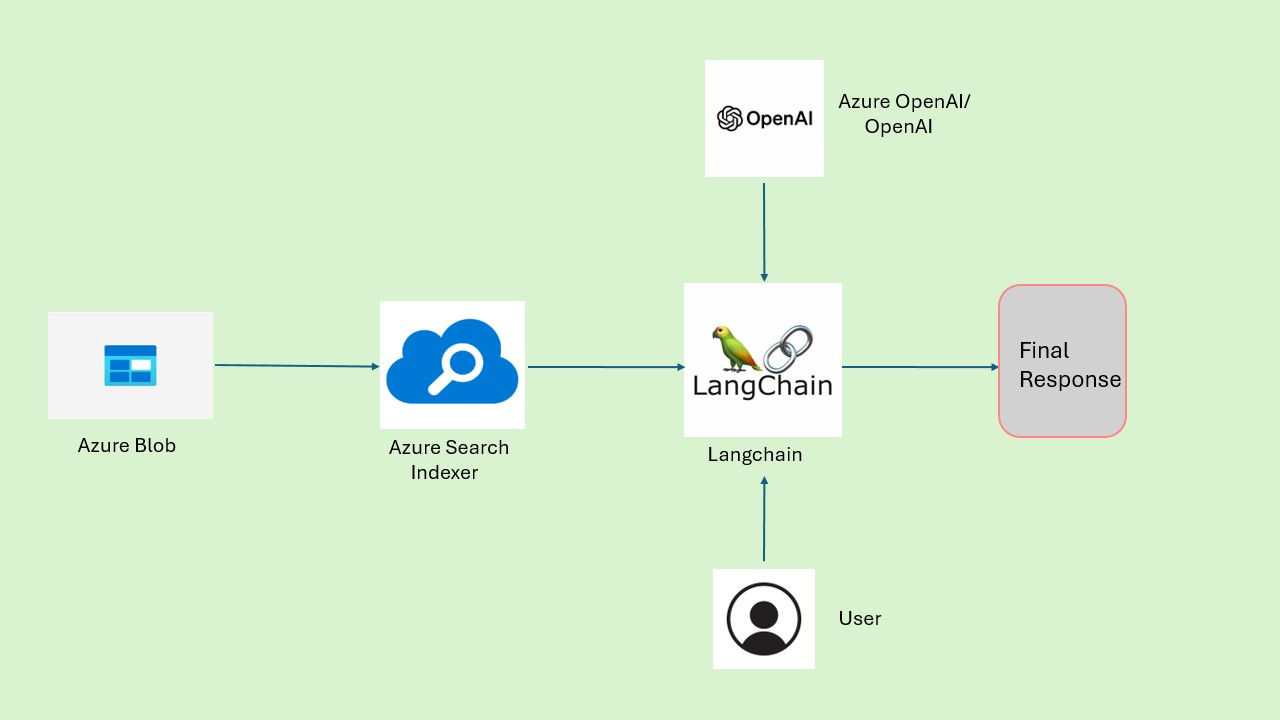

In [1]:
%pip install azure-data-tables
%pip install --upgrade --quiet langchain-community
%pip install --upgrade --quiet langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.1 MB/s eta 0:00:00


In [5]:
import os  # Import the os module to interact with the operating system
from dotenv import load_dotenv
load_dotenv("../azureopenai.env")

True

In [ ]:
#Create an Azure Table based on the File / Private Knowledge Base

import csv
from azure.data.tables import TableServiceClient, TableEntity

# Set up your Azure Table Storage connection
connection_string = "dummyKey"
table_name = "BMWDATA"

# Create a TableServiceClient
table_service = TableServiceClient.from_connection_string(conn_str=connection_string)

# Create a table if it doesn't exist
try:
    table_service.create_table(table_name)
except Exception as e:
    print(f"Table already exists: {e}")

# Read the CSV file and upload the data
csv_file_path = "bmw.csv"

with open(csv_file_path, mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Create a new entity
        entity = TableEntity()
        entity['PartitionKey'] = "BMW_FAQ"  # You can set this to whatever makes sense
        entity['RowKey'] = row['ID']  # Use ID as RowKey
        entity['Question'] = row['Question']
        entity['Answer'] = row['Answer']

        # Upload the entity to the table
        table_service.get_table_client(table_name).create_entity(entity=entity)
        print(f"Uploaded: {entity['RowKey']} - {entity['Question']}")

print("Data upload complete.")


Uploaded: 1 - What are the available models of BMW in 2024?
Uploaded: 2 - What is the warranty period for BMW cars?
Uploaded: 3 - What is the cost of BMW i4 electric car?
Uploaded: 4 - What type of fuel is recommended for BMW cars?
Uploaded: 5 - How often should I service my BMW?
Uploaded: 6 - Can I charge a BMW electric car at home?
Uploaded: 7 - What is the top speed of the BMW M4?
Uploaded: 8 - Are BMW cars equipped with autonomous driving features?
Uploaded: 9 - What are the safety features in BMW cars?
Uploaded: 10 - What is BMW ConnectedDrive?
Uploaded: 11 - What is the fuel economy of the BMW 3 Series?
Uploaded: 12 - What is the lifespan of a BMW battery?
Uploaded: 13 - How do I reset the service light on my BMW?
Uploaded: 14 - What is BMW's approach to sustainability?
Uploaded: 15 - How does BMW's All-Wheel Drive system work?
Uploaded: 16 - What are the interior features of the BMW X5?
Uploaded: 17 - What are the differences between the BMW M and regular models?
Uploaded: 18 - 

Before running the code, make sure to create an Azure Cognitive Search index:
Set Up Azure Search Service:
Log in to the Azure portal. Search for "Azure Cognitive Search" and click Create. Provide details like Subscription, Resource Group, Service Name, and Region, then create the service.
Create an Index with Import Data:
Once the service is created, go to Overview > Import Data. Choose a data source (like Azure Blob Storage, SQL Database, or custom data). Follow the prompts to select your data and configure the fields (e.g., id, Answer). The system will create the index automatically based on your data structure.
Set Environment Variables: After creating the index, set the necessary environment variables

In [ ]:
# Step 2: Set the environment variables for Azure AI Search
# These variables configure the search service and index for retrieving documents

# Set the Azure AI Search service name
os.environ["AZURE_AI_SEARCH_SERVICE_NAME"] = "azaisearch-new"

# Set the Azure AI Search index name to query
os.environ["AZURE_AI_SEARCH_INDEX_NAME"] = "azuretable-index"

# Set the Azure AI Search API key for authentication
os.environ["AZURE_AI_SEARCH_API_KEY"] = "dummyKey"

# **Initialize the Retriever, Prompt, and LLM**

In [9]:
# Import necessary libraries and modules from Langchain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import AzureChatOpenAI
from langchain_community.retrievers import AzureAISearchRetriever

# Step 1: Initialize the AzureAI Search Retriever
# This retrieves relevant documents based on the user query from the Azure Search index
retriever = AzureAISearchRetriever(
    content_key="Answer",  # The key for the content field in the search results change it accordingly as per your data
    top_k=1,              # Number of top results to retrieve
    index_name="azuretable-index"  # Name of the Azure Search index to query
)

# Step 2: Define the prompt template for the language model
# This sets up how the context and question will be formatted for the model
prompt = ChatPromptTemplate.from_template(
    """Answer the question based only on the context provided.

Context: {context}  # Placeholder for the context from the retriever

Question: {question}  # Placeholder for the user question"""
)

# Step 3: Initialize the Azure Chat OpenAI model
# This sets up the model to be used for generating responses
llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),  # Fetch the Azure OpenAI endpoint from environment variables
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),          # Fetch the API key for Azure OpenAI from environment variables
    api_version="2024-05-01-preview",                    # Specify the API version to use
    model="gpt-35-turbo-16k"                              # Specify the model to use
)

**Processing Chain and User Input Loop**

In [10]:


# Step 4: Create a processing chain
# This chain will process the retrieved context and the user question
chain = (
    {"context": retriever , "question": RunnablePassthrough()}  # Set context using the retriever and format it
    | prompt                                                               # Pass the formatted context and question to the prompt
    | llm                                                                  # Generate a response using the language model
    | StrOutputParser()                                                   # Parse the output to a string format
)

# Step 5: Infinite loop for user input
while True:
    # Prompt the user to enter a question or type 'end' to exit
    user_question = input("Please enter your question (or type 'end' to exit): ")

    # Check if the user wants to exit the loop
    if user_question.lower() == "end":
        print("Exiting the loop. Goodbye!")  # Inform the user that the loop is ending
        break  # Break the loop and exit

    # Step 7: Invoke the processing chain with the user's question
    response = chain.invoke(user_question)  # Get the response from the chain based on the user question
    print("Response:", response)  # Print the model's response to the console


Please enter your question (or type 'end' to exit): best bmw in electric
Response: Based on the given context, it is not possible to determine the best BMW electric vehicle.
Please enter your question (or type 'end' to exit): price of bmw electric
Response: The cost of the BMW i4 electric car starts at around $55,000.
Please enter your question (or type 'end' to exit): the most expensive model of MW
Response: The most expensive model of BMW is not mentioned in the given context.
Please enter your question (or type 'end' to exit): most expensive car as per given data
Response: The most expensive car cannot be determined based on the given data.
Please enter your question (or type 'end' to exit): top safety features
Response: The top safety features in BMW cars include Dynamic Stability Control, Automatic Emergency Braking, Lane Departure Warning, and advanced airbags.
Please enter your question (or type 'end' to exit): give as bullet points
Response: - Comfort mode
- Sport mode
- Eco Pr

KeyboardInterrupt: Interrupted by user

**Upload your data into azure table storage**